In [1]:
#Import libraries
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import librosa
import os
import numpy as np
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
#5 birbs!!

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
birbs = ['aldfly', 'ameavo', 'amebit', 'amecro', 'amegfi']
for birb in birbs:
    print(birb)
    for filename in os.listdir(f'/content/drive/My Drive/MLSP/train_audio_5/{birb}'):
        songname = f'/content/drive/My Drive/MLSP/train_audio_5/{birb}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=15)
        rmse = librosa.feature.rmse(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {birb}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())



aldfly
ameavo
amebit
amecro
amegfi


In [28]:
os.listdir(f'/content/drive/My Drive/MLSP/train_audio_5/')

['aldfly', 'amegfi', 'amecro', 'amebit', 'ameavo']

In [3]:
data = pd.read_csv('dataset.csv')
data.head()
data = data.drop(['filename'],axis=1)
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
data.to_csv('dataset.csv')
!cp dataset.csv "drive/My Drive/"

In [ ]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=50)

Epoch 1/20
7/7 [==============================] - 0s 2ms/step - loss: 2.1153 - accuracy: 0.3049
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 1.6004 - accuracy: 0.6197
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 1.2656 - accuracy: 0.6754
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 1.0036 - accuracy: 0.6885
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7650 - accuracy: 0.7443
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.8361
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4623 - accuracy: 0.8787
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3563 - accuracy: 0.8918
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 0.9246
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.9475
Epoch 11/20
7/7 [======================

In [11]:
model.evaluate(x=X_test, y=y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.3882 - accuracy: 0.8701


[0.38820430636405945, 0.8701298832893372]

In [ ]:
# don't run this stuff and the rest from here 

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('train_dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
birbs = os.listdir(f'/content/drive/My Drive/MLSP/train_audio/')[:20]
for birb in birbs:
    print(birb)
    for filename in os.listdir(f'/content/drive/My Drive/MLSP/train_audio/{birb}'):
        songname = f'/content/drive/My Drive/MLSP/train_audio/{birb}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=15)
        rmse = librosa.feature.rmse(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {birb}'
        file = open('train_dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())



In [19]:
data = pd.read_csv('train_dataset.csv')
data.head()
data = data.drop(['filename'],axis=1)
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

data.to_csv('train_dataset.csv')
!cp train_dataset.csv "drive/My Drive/"

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

classifier = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=50)

In [ ]:
model.evaluate(x=X_test, y=y_test)

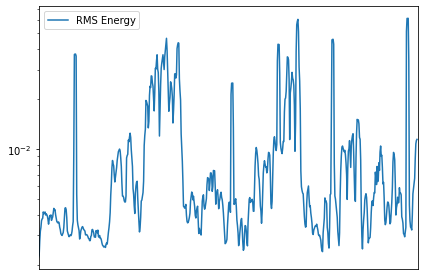

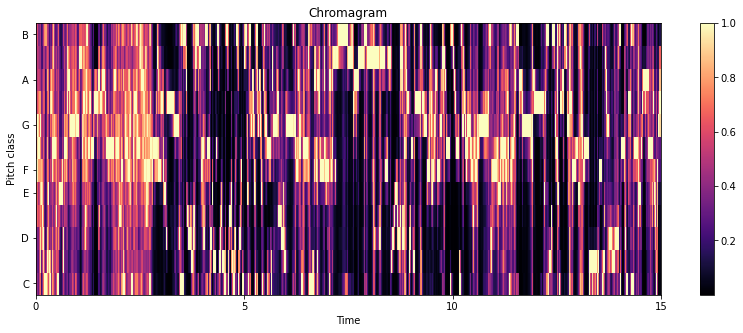

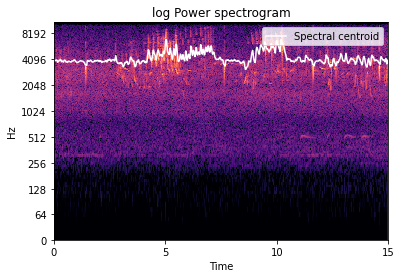

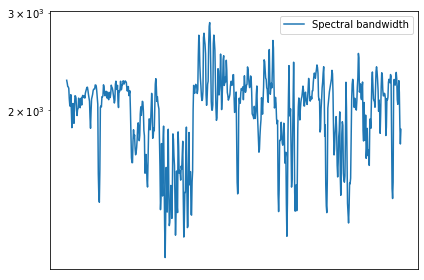

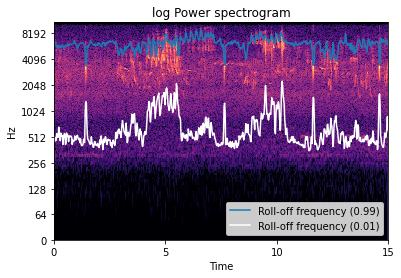

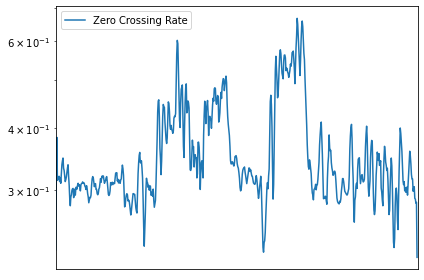

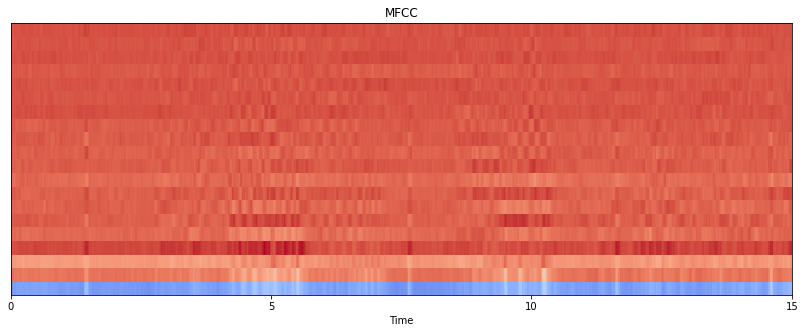

In [34]:
import matplotlib.pyplot as plt
import librosa.display

birbs = ['aldfly', 'ameavo', 'amebit', 'amecro', 'amegfi']
for birb in birbs:
    for filename in os.listdir(f'/content/drive/My Drive/MLSP/train_audio_5/{birb}'):
        songname = f'/content/drive/My Drive/MLSP/train_audio_5/{birb}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=15)
        rmse = librosa.feature.rmse(y=y)
        plt.figure()
        plt.semilogy(rmse.T, label='RMS Energy')
        plt.xticks([])
        plt.xlim([0, rmse.shape[-1]])
        plt.legend(loc='best')
        plt.tight_layout()

        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(chroma_stft, sr=sr, y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.title('Chromagram')

        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        S, phase = librosa.magphase(librosa.stft(y=y))
        times = librosa.times_like(spec_cent)
        fig, ax = plt.subplots()
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
        ax.plot(times, spec_cent.T, label='Spectral centroid', color='w')
        ax.legend(loc='upper right')
        ax.set(title='log Power spectrogram')

        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        plt.figure()
        plt.semilogy(spec_bw[0], label='Spectral bandwidth')
        plt.xticks([])
        plt.legend(loc='best')
        plt.tight_layout()


        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)
        fig, ax = plt.subplots()
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
        ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
        ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
        ax.legend(loc='lower right')
        ax.set(title='log Power spectrogram')

        zcr = librosa.feature.zero_crossing_rate(y)
        plt.figure()
        plt.semilogy(zcr[0], label='Zero Crossing Rate')
        plt.xticks([])
        plt.xlim([0, rmse.shape[-1]])
        plt.legend(loc='best')
        plt.tight_layout()

        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mfcc, x_axis='time')           
        plt.title('MFCC')

        break
    break

